# GEE 教程（七）：长江流域降雨量可视化分析

In [1]:
import ee
import geemap
ee.Initialize()
geemap.set_proxy(port="7890")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1 加载相关数据

### 1.1 加载本地的长江流域shp

In [3]:
yangtzeBasin = geemap.shp_to_ee('E:/researchData/Yangtze/YangtzeBasin.shp')

In [4]:
Map = geemap.Map()
Map.centerObject(yangtzeBasin, 5)
Map.addLayer(yangtzeBasin, {}, '长江流域')
Map

Map(center=[30.23479495214304, 107.24266148024736], controls=(WidgetControl(options=['position', 'transparent_…

### 1.2 设置起止时间

In [5]:
startYear = 2013
endYear = 2022
# 为开始年份和结束年份创建两个日期对象
startDate = ee.Date.fromYMD(startYear, 1, 1)
endDate = ee.Date.fromYMD(endYear + 1, 1, 1)
# 创建一个年份列表
years = ee.List.sequence(startYear, endYear)
# 创建一个月份列表
months = ee.List.sequence(1, 12)

### 1.3 加载 CHIRPS 数据集

In [6]:
CHIRPS = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
CHIRPS = CHIRPS.filterDate(startDate, endDate)

## 2 计算每月总降雨量

In [7]:
# 该函数应用一个嵌套循环，首先在相关年份进行映射，然后在相关月份进行映射
# 返回值是一个包含月度降雨量(P)波段图像
def caculate_months(y):
    def caculate_all(m):
        # 筛选出每月降雨量并求出当月总和
        P = CHIRPS.filter(ee.Filter.eq('year', y)) \
                .filter(ee.Filter.eq('month', m)) \
                .sum()
        # 返回一个图像，只含有一个降雨量波段
        return P.set('year', y) \
                .set('month', m) \
                .set('date', ee.Date.fromYMD(y, m, 1))
    return months.map(caculate_all)
# flatten() 将特征的特征集合转换为单个特征集合
# 再将结果转化为 ImageCollection
monthlyPrecip = ee.ImageCollection.fromImages(
    years.map(caculate_months).flatten()
)

## 3 结果可视化

### 3.1 月均降水量数据地图可视化

In [8]:
# 添加长江流域的月均值图层
precipVis = {
  'min': 0,
  'max': 250,
  'palette': ['white', 'blue', 'darkblue', 'red', 'purple']
}
Map.addLayer(monthlyPrecip.mean().clip(yangtzeBasin), precipVis, '月均降水')
Map

Map(center=[30.23479495214304, 107.24266148024736], controls=(WidgetControl(options=['position', 'transparent_…

### 3.2 将降雨量数据提取成 excel 表格

In [9]:
region = yangtzeBasin.geometry()

In [10]:
# 定义一个函数，用于对每个影像的降雨量波段数值求均值，
# 并返回一个包含降雨量和时间属性的Feature
def get_precip_mean_date(image):
    # 对降雨量波段数值求均值，使用ee.Reducer.mean()方法，并指定区域和缩放比例
    mean = image.reduceRegion(ee.Reducer.mean(), region, 5000).get('precipitation')
    # 获取影像的日期，使用ee.Date()方法，并格式化为YYYY-MM-dd
    date = ee.Date(image.get('date')).format('YYYY-MM-dd')
    # 返回一个包含降雨量和时间的要素，使用ee.Feature()方法，并设置几何和属性
    return ee.Feature(None, {'date': date, 'precip_mean': mean})

# 使用ee.ImageCollection.map()方法来对影像集合中每个影像应用上面定义的函数
# map()函数返回的是一个ee.ComputedObject类型的对象
# 需要将结果转化为ee.FeatureCollection，
# 才能利用geemap包转化成DataFrame格式
precip_mean = ee.FeatureCollection(monthlyPrecip.map(get_precip_mean_date))

In [11]:
# 将数据转化为 DataFrame 格式
df = geemap.ee_to_pandas(precip_mean)
df

,date,precip_mean
0,2013-01-01,17.657346
1,2013-02-01,34.355689
2,2013-03-01,81.704462
3,2013-04-01,85.885359
4,2013-05-01,154.191976
...,...,...
115,2022-08-01,82.300766
116,2022-09-01,82.628146
117,2022-10-01,61.459835
118,2022-11-01,42.323558


In [12]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
outputFile = './output/yangtze_precip_chart_monthly.xlsx'
df.to_excel(outputFile, index=False)

### 3.3 绘制降雨量直方图

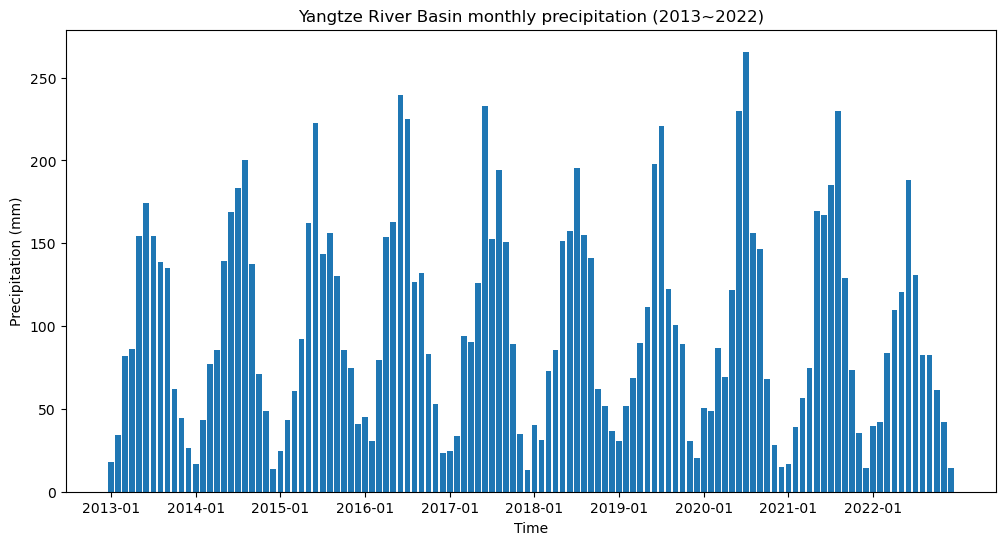

In [16]:
df = pd.read_excel(outputFile)
# 设置图形的大小
plt.figure(figsize=(12, 6))

# 将date读取为只显示年份-月份的形式
df['date'] = df['date'].dt.strftime('%Y-%m')

# 绘制柱状图，使用日期作为x轴，平均降水量作为y轴
plt.bar(df['date'], df['precip_mean'])

# 设置x轴的刻度，每隔1年(12个日期)显示一个标签
plt.xticks(np.arange(0, len(df), 12))

# 设置x轴和y轴的标签
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')

# 设置图形的标题
plt.title('Yangtze River Basin monthly precipitation (2013~2022)')

# 显示图形
plt.show()